In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from scipy.stats import lognorm, kstest

In [2]:
mit, oxford, rwth, eth = pd.read_csv('./data/MIT.csv', index_col=0), pd.read_csv('./data/University of Oxford.csv', index_col=0), pd.read_csv('./data/RWTH Aachen University.csv', index_col=0), pd.read_csv('./data/ETH Zurich.csv', index_col=0) 

In [3]:
mit

,Researcher,H-index,Citations,Publications,University Name,Country
0,Alex Pentland,144,131625,762,MIT,United States
1,Tomaso Poggio,141,113834,593,MIT,United States
2,Antonio Torralba,133,106068,390,MIT,United States
3,Hari Balakrishnan,129,146077,308,MIT,United States
4,William T. Freeman,128,92649,390,MIT,United States
...,...,...,...,...,...,...
143,Joseph P. Campbell,33,4896,72,MIT,United States
144,Mohsen Ghaffari,33,3631,136,MIT,United States
145,Daniel Gruhl,32,15790,139,MIT,United States
146,Daniel Sanchez,32,4757,88,MIT,United States


In [4]:
def add_cdf(df):
    ''' adds a row for cumulative h-index of the the scholars '''
    
    df = df.sort_values('H-index', ascending=True)
    df['Cumulative H-index'] = df['H-index'].cumsum()
    df = df.sort_values('H-index', ascending=False)

    return df

def add_hps(df):
    """ adds a row for the h-index per scholar of the university. this is meant for the computer science and not the university rankings """
    
    assert 'Scholars' in df.columns, 'This seems to be a university ranking and not a computer science ranking. The table needs a scholars column.'
    
    df['H-index per Scholar'] = df['H-index'] / df['Scholars']

    df_sorted = df.sort_values(by='H-index per Scholar', ascending=False)
    
    df_sorted['Rank'] = df_sorted['H-index per Scholar'].rank(ascending=False, method='dense').astype(int)
    
    return df

In [5]:
mit, oxford, rwth, eth = [add_cdf(df) for df in [mit, oxford, rwth, eth]]

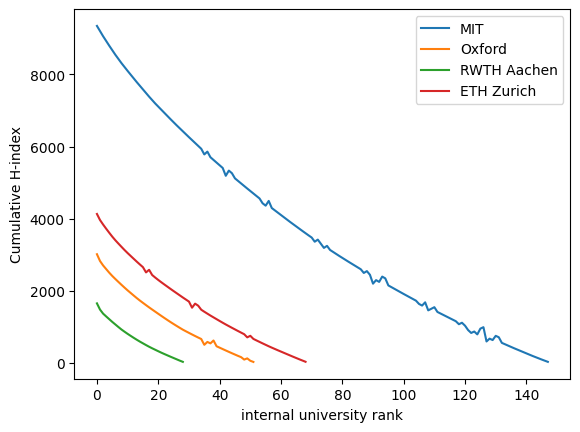

In [6]:
# plot the cumulative h-index for all universities
fig, ax = plt.subplots()

ax.plot(range(len(mit)), mit['Cumulative H-index'] , label='MIT')
ax.plot(range(len(oxford)), oxford['Cumulative H-index'] , label='Oxford')
ax.plot(range(len(rwth)), rwth['Cumulative H-index'] , label='RWTH Aachen')
ax.plot(range(len(eth)), eth['Cumulative H-index'] , label='ETH Zurich')

plt.xlabel('internal university rank')
plt.ylabel('Cumulative H-index')
plt.legend()
pass

MIT K-S vs RWTH test statistic: 0.18359739049394222
MIT K-S vs RWTH test p-value: 0.3389386335714126
Oxford K-S vs RWTH test statistic: 0.09748010610079576
Oxford K-S vs RWTH test p-value: 0.9835961428648319
ETH Zurich vs RWTH K-S test statistic: 0.1329335332333833
ETH Zurich vs RWTH K-S test p-value: 0.8073493714451643


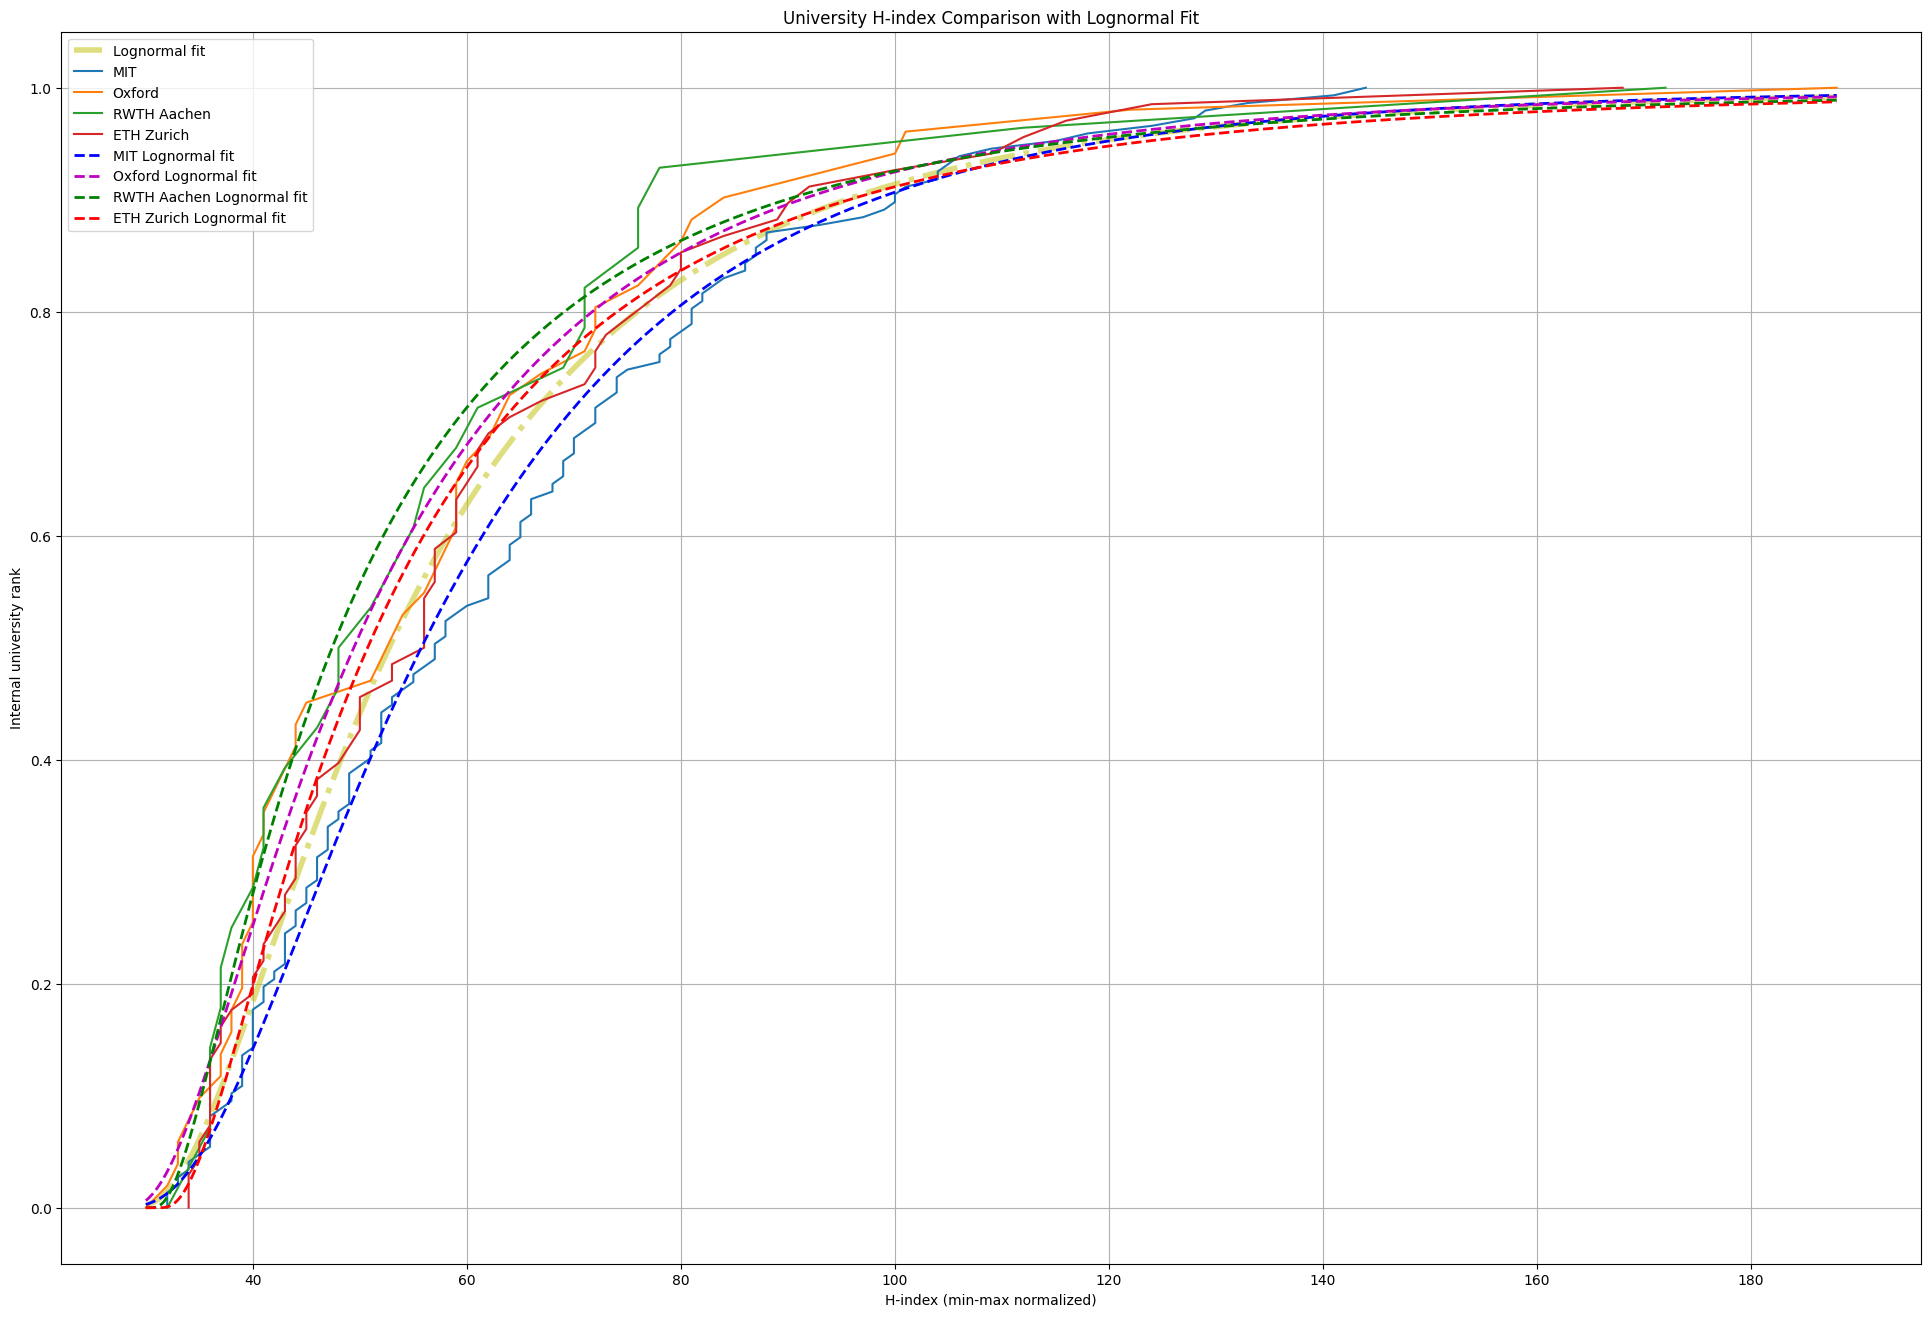

In [14]:
normalize_01 = lambda data: (data - np.min(data)) / (np.max(data) - np.min(data))

# Fit lognormal distribution to each dataset
mit_shape, mit_loc, mit_scale = lognorm.fit(mit['H-index'])
oxford_shape, oxford_loc, oxford_scale = lognorm.fit(oxford['H-index'])
rwth_shape, rwth_loc, rwth_scale = lognorm.fit(rwth['H-index'])
eth_shape, eth_loc, eth_scale = lognorm.fit(eth['H-index'])

# Fit a lognormal distribution to combined data
h_index = pd.concat([mit['H-index'], oxford['H-index'], rwth['H-index'], eth['H-index']])
shape, loc, scale = lognorm.fit(h_index)

# Run Test for each dataset, if i understand this correctly this answers the question whether the data stems from a single distribution. is this what i should test for?
mit_ks_stat, mit_ks_p_value = kstest(rwth['H-index'], mit['H-index'])
oxford_ks_stat, oxford_ks_p_value = kstest(rwth['H-index'], oxford['H-index'])
eth_ks_stat, eth_ks_p_value = kstest(rwth['H-index'], eth['H-index'])

# Results
print("MIT K-S vs RWTH test statistic:", mit_ks_stat)
print("MIT K-S vs RWTH test p-value:", mit_ks_p_value)

print("Oxford K-S vs RWTH test statistic:", oxford_ks_stat)
print("Oxford K-S vs RWTH test p-value:", oxford_ks_p_value)

print("ETH Zurich vs RWTH K-S test statistic:", eth_ks_stat)
print("ETH Zurich vs RWTH K-S test p-value:", eth_ks_p_value)

# Plot the data and the lognormal fit
fig, ax = plt.subplots(figsize=(24, 16))

x_fit = np.linspace(min(h_index), max(h_index), 1000)
y_fit = lognorm.cdf(x_fit, shape, loc, scale)

ax.plot(x_fit, y_fit, 'y-.', linewidth=4, label='Lognormal fit', alpha=0.5)

ax.plot(mit['H-index'], 1 - normalize_01(range(len(mit))), label='MIT')
ax.plot(oxford['H-index'], 1 - normalize_01(range(len(oxford))), label='Oxford')
ax.plot(rwth['H-index'], 1 - normalize_01(range(len(rwth))), label='RWTH Aachen')
ax.plot(eth['H-index'], 1 - normalize_01(range(len(eth))), label='ETH Zurich')

x_fit = np.linspace(min(mit['H-index'].min(), oxford['H-index'].min(), rwth['H-index'].min(), eth['H-index'].min()), 
                    max(mit['H-index'].max(), oxford['H-index'].max(), rwth['H-index'].max(), eth['H-index'].max()), 1000)

mit_y_fit = lognorm.cdf(x_fit, mit_shape, mit_loc, mit_scale)
oxford_y_fit = lognorm.cdf(x_fit, oxford_shape, oxford_loc, oxford_scale)
rwth_y_fit = lognorm.cdf(x_fit, rwth_shape, rwth_loc, rwth_scale)
eth_y_fit = lognorm.cdf(x_fit, eth_shape, eth_loc, eth_scale)

ax.plot(x_fit, mit_y_fit, 'b--', linewidth=2, label='MIT Lognormal fit')
ax.plot(x_fit, oxford_y_fit, 'm--', linewidth=2, label='Oxford Lognormal fit')
ax.plot(x_fit, rwth_y_fit, 'g--', linewidth=2, label='RWTH Aachen Lognormal fit')
ax.plot(x_fit, eth_y_fit, 'r--', linewidth=2, label='ETH Zurich Lognormal fit')

ax.set_xlabel('H-index (min-max normalized)')
ax.set_ylabel('Internal university rank')
ax.legend()
ax.grid(True)
ax.set_title('University H-index Comparison with Lognormal Fit')

plt.show()

In [9]:
# Print fitted parameters
print(f"Shape parameter: {shape}")
print(f"Location parameter: {loc}")
print(f"Scale parameter: {scale}")

Shape parameter: 0.7675662950057721
Location parameter: 27.20708953163883
Scale parameter: 25.52358448933771


In [10]:
f'''Percentage of scientists listed with an H-index higher than 50 at: MIT: {len(mit[mit['H-index'] < 50])/len(mit)}, RWTH: {len(rwth[rwth['H-index'] < 50])/len(rwth)}'''

'Percentage of scientists listed with an H-index higher than 50 at: MIT: 0.3918918918918919, RWTH: 0.5172413793103449'